Modèle Stat ARIMA... (SARIMA)


librairie : statmodel (library, package ARIMA)


Model LLM, Ollama, TimeCHATGPT...

à compléter et battre le BTC tout seul est quasiment impossible 

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, LSTM, Bidirectional
from tensorflow.keras.activations import linear, relu, sigmoid
from sklearn.decomposition import PCA

from modules.utils import feature_engineering_last, filter_data_by_year_month

from sklearn.model_selection import train_test_split

In [12]:
X = pd.read_csv("Historical Prices for BTCUSDT")

In [13]:
YEARS = [2020, 2021, 2022, 2023, 2024, 2025]

Data = filter_data_by_year_month(X, YEARS)

df = feature_engineering_last(X)

In [15]:
y = df["target"]

df_without_target = df.drop(columns=["target"], errors="ignore")  # Only keep features

pca = PCA()
pca.fit(df_without_target)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = (
    np.argmax(explained_variance >= 0.95) + 1
)  # Find min components for 95% variance

if num_components == 0:
    print("⚠️ No PCA components meet 95% explained variance. Using 1 component.")
    num_components = 1

print(f"✅ Optimal number of components: {num_components}")

# ✅ Step 2: Fit PCA with optimal number of components
pca = PCA(n_components=num_components)
X_reduced = pca.fit_transform(df_without_target)

# ✅ Convert back to DataFrame and restore index
columns = [f"PC{i+1}" for i in range(num_components)]
X_pca_df = pd.DataFrame(
    X_reduced, columns=columns, index=df.index
)  # Keep original index

X_pca_df["target"] = y  # Add target column back

✅ Optimal number of components: 5


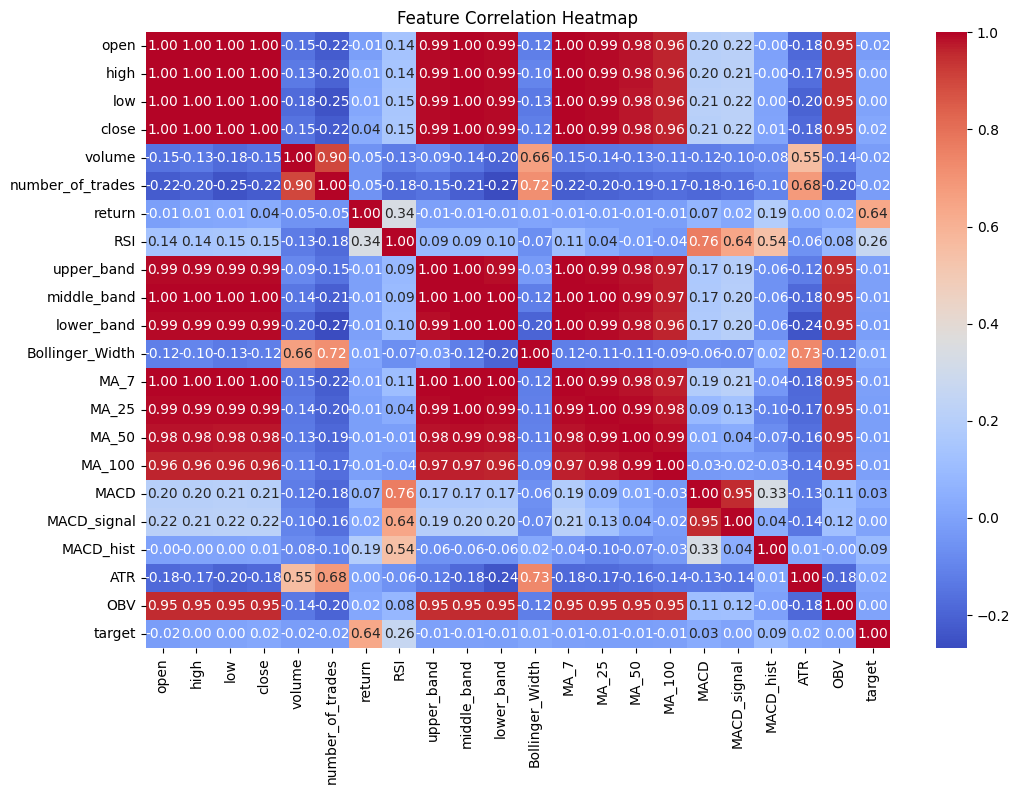

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
print(df["target"].value_counts(normalize=True))

In [ ]:
# Check for NaN values in the entire DataFrame
print(df.isnull().sum())

In [5]:
df.head(10)

,open,high,low,close,volume,number_of_trades,return,RSI,upper_band,middle_band,lower_band,Bollinger_Width,MA_7,MA_25,MA_50,MA_100,MACD,MACD_signal,MACD_hist,ATR,OBV,target
100,0.004070,0.004106,0.004155,0.003988,0.023472,0.005843,-0.002531,0.707136,0.004013,0.003468,0.002873,0.014659,0.003654,0.003129,0.002991,0.002911,0.508652,0.512247,0.450707,0.008936,0.271657,0
101,0.003985,0.003938,0.003963,0.003891,0.009838,0.004210,-0.002686,0.658770,0.004063,0.003534,0.002954,0.014386,0.003742,0.003170,0.003005,0.002918,0.508802,0.512939,0.449665,0.009116,0.271208,0
102,0.003889,0.003824,0.003947,0.003825,0.009466,0.003744,-0.001858,0.626677,0.004072,0.003597,0.003071,0.013357,0.003822,0.003207,0.003016,0.002926,0.508672,0.513464,0.448328,0.008894,0.270776,0
103,0.003845,0.003851,0.004013,0.003897,0.009093,0.003796,0.002027,0.646516,0.004060,0.003669,0.003228,0.011751,0.003894,0.003253,0.003029,0.002933,0.508675,0.513884,0.447496,0.008553,0.271191,1
104,0.003901,0.003937,0.004042,0.003881,0.008321,0.003099,-0.000458,0.638055,0.004029,0.003729,0.003381,0.009987,0.003859,0.003298,0.003042,0.002941,0.508557,0.514193,0.446614,0.008448,0.270811,0
105,0.003875,0.003858,0.004041,0.003917,0.003850,0.002126,0.000995,0.648598,0.003938,0.003795,0.003606,0.006955,0.003851,0.003339,0.003054,0.002949,0.508478,0.514423,0.445977,0.008044,0.270987,1
106,0.003920,0.003882,0.004103,0.003928,0.003084,0.002301,0.000320,0.652116,0.003795,0.003848,0.003861,0.003124,0.003830,0.003379,0.003067,0.002957,0.508368,0.514582,0.445414,0.007526,0.271128,1
107,0.003926,0.003844,0.003967,0.003822,0.007355,0.002717,-0.002982,0.591185,0.003737,0.003818,0.003859,0.002579,0.003806,0.003410,0.003078,0.002964,0.507940,0.514612,0.444387,0.007423,0.270792,0
108,0.003819,0.003781,0.003988,0.003839,0.005603,0.002200,0.000485,0.597597,0.003728,0.003805,0.003843,0.002640,0.003798,0.003439,0.003090,0.002971,0.507577,0.514554,0.443685,0.006999,0.271047,1
109,0.003831,0.003862,0.004017,0.003943,0.004234,0.002294,0.002923,0.634965,0.003668,0.003791,0.003877,0.001723,0.003815,0.003466,0.003103,0.002979,0.507490,0.514488,0.443621,0.006809,0.271241,1


In [16]:
# df = df.replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
# df = df.fillna(df.mean())

X = X_pca_df.drop(columns=["target"]).values  # Features
y = X_pca_df["target"].values  # Target variable


# Reshape the data into sequences (timesteps)
timesteps = 5  # Number of timesteps for the RNN
X_sequences = []
y_sequences = []

for i in range(len(X) - timesteps):
    X_sequences.append(X[i : i + timesteps])
    y_sequences.append(y[i + timesteps])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

split_index = int(len(X_sequences) * 0.8)  # 80% train, 20% test
X_train, X_test = X_sequences[:split_index], X_sequences[split_index:]
y_train, y_test = y_sequences[:split_index], y_sequences[split_index:]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (5192, 5, 5), Test shape: (1298, 5, 5)


In [21]:
X_train.shape

(5192, 5, 5)

In [22]:
y_train.shape

(5192,)

In [ ]:
print(np.isnan(X).any(), np.isnan(y).any())  # Check for NaN
print(np.isinf(X).any(), np.isinf(y).any())

In [ ]:
# dataset = tf.data.Dataset.from_tensor_slices((X1, y))
# # Calculate sizes for train and validation sets
# dataset_size = len(X1)  # Total number of samples in your dataset
# train_size = int(0.8 * dataset_size)

# # Shuffle the dataset if needed
# dataset = dataset.shuffle(buffer_size=dataset_size)

# # Split the dataset
# train_dataset = dataset.take(train_size)       # Take the first 80%
# val_dataset = dataset.skip(train_size)         # Skip the first 80%, take the remaining 20%

# # Batch both datasets if needed
# batch_size = 32
# train_dataset = train_dataset.batch(batch_size)
# val_dataset = val_dataset.batch(batch_size)

In [ ]:
tf.random.set_seed(1234)  # for consistent results

# Simplified GRU Model
model1 = Sequential(
    [
        # Single GRU Layer
        GRU(64, input_shape=(10, X_sequences.shape[2]), name="GRU_Layer"),
        Dropout(0.2, name="Dropout_Layer"),  # Regularization
        # Fully Connected Dense Layer
        Dense(32, activation="relu", name="Dense_Layer"),  # Hidden dense layer
        # Output Layer for Binary Classification
        Dense(1, activation="sigmoid", name="Output_Layer"),  # Predict binary output
    ]
)

In [7]:
tf.random.set_seed(1234)  # for consistent results


model2 = Sequential(
    [
        Bidirectional(
            LSTM(128, return_sequences=True),
            input_shape=(X_train.shape[1], X_train.shape[2]),
        ),
        Dropout(0.2),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid"),  # Binary classification
    ]
)

/Users/elouan/anaconda3/envs/Predicting_crypto/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
tf.random.set_seed(1234)  # for consistent results

model3 = Sequential(
    [
        Bidirectional(
            LSTM(256, return_sequences=True),
            input_shape=(X_train.shape[1], X_train.shape[2]),
        ),
        Dropout(0.2),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid"),  # Binary classification
    ]
)

In [ ]:
model3.summary()

In [19]:
model_ = tf.keras.models.load_model("../models/RNN(O.5646)_high(0.55)_low_(0.44).keras")

In [8]:
# Compile the model
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),  # 🔥 Pour classification binaire
    metrics=["accuracy"],
)

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,  # Reduce LR by 90% instead of 50%
    patience=3,
    min_lr=1e-6,  # Set a minimum learning rate
)

# Model checkpoint callback
checkpoint = ModelCheckpoint(
    filepath="../models/RNN_LTSM_model2.keras",  # Save the model to this path
    monitor="val_accuracy",  # Monitor validation accuracy
    mode="max",  # Save when accuracy is maximized
    save_best_only=True,  # Save only if the model improves
    verbose=1,  # Display a message when saving
)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model2.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,  # Increase epochs for better training
    batch_size=32,
    callbacks=[reduce_lr, checkpoint, early_stop],  # Add early stopping
)

Epoch 1/100
5338/5339 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5029 - loss: 0.6936
Epoch 1: val_accuracy improved from -inf to 0.50380, saving model to ../models/RNN_LTSM_model2.keras
5339/5339 ━━━━━━━━━━━━━━━━━━━━ 100s 18ms/step - accuracy: 0.5029 - loss: 0.6936 - val_accuracy: 0.5038 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 2/100
5338/5339 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5236 - loss: 0.6914
Epoch 2: val_accuracy improved from 0.50380 to 0.51825, saving model to ../models/RNN_LTSM_model2.keras
5339/5339 ━━━━━━━━━━━━━━━━━━━━ 109s 20ms/step - accuracy: 0.5236 - loss: 0.6914 - val_accuracy: 0.5183 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 3/100
5337/5339 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5351 - loss: 0.6900
Epoch 3: val_accuracy improved from 0.51825 to 0.52534, saving model to ../models/RNN_LTSM_model2.keras
5339/5339 ━━━━━━━━━━━━━━━━━━━━ 120s 22ms/step - accuracy: 0.5351 - loss: 0.6900 - val_accuracy: 0.5253 - val_loss: 0.6913 - learn

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prédictions sur le test set
y_pred_prob = model_.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convertir en 0 ou 1

# Calculer l’accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Afficher un rapport détaillé (Precision, Recall, F1-score)
print(classification_report(y_test, y_pred))

# Matrice de confusion
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 5 and 6 for '{{node sequential_1/bidirectional_1/forward_lstm_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/bidirectional_1/forward_lstm_1/strided_slice_1, sequential_1/bidirectional_1/forward_lstm_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [32,5], [6,512].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(32, 5), dtype=float32)
  • states=('tf.Tensor(shape=(32, 128), dtype=float32)', 'tf.Tensor(shape=(32, 128), dtype=float32)')
  • training=False

In [ ]:
import matplotlib.pyplot as plt

df_test = pd.DataFrame({"Actual Return": y_test, "Predicted": y_pred.flatten()})
df_test["Signal"] = df_test["Predicted"].shift(
    1
)  # Décalage pour éviter la fuite d’info

# Appliquer les signaux pour simuler une stratégie
df_test["Strategy Return"] = df_test["Signal"] * df_test["Actual Return"]
df_test["Cumulative Return"] = df_test["Strategy Return"].cumsum()

# Afficher la performance de la stratégie
plt.figure(figsize=(12, 6))
plt.plot(df_test["Cumulative Return"], label="LSTM Trading Strategy", color="green")
plt.title("Backtest: Cumulative Returns of LSTM Strategy")
plt.legend()
plt.show()

------------------

RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train_2D = X_train.reshape(X_train.shape[0], -1)  # Flatten
X_test_2D = X_test.reshape(X_test.shape[0], -1)  # Flatten

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_2D, y_train)

# Predict & Evaluate
y_pred_rf = rf.predict(X_test_2D)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

-------------

XGboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Train an XGBoost classifier
xgb = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
xgb.fit(X_train_2D, y_train)

# Make predictions
y_pred_xgb = xgb.predict(X_test_2D)

# Evaluate accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")

Feature importance

In [ ]:
import matplotlib.pyplot as plt

# Get feature importance
importance = xgb.feature_importances_

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(importance)), importance)
plt.title("XGBoost Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()